In [36]:
import cv2 as cv
import numpy as np
from PIL import Image
import IPython
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
def imshow(img):
    _, ret = cv.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

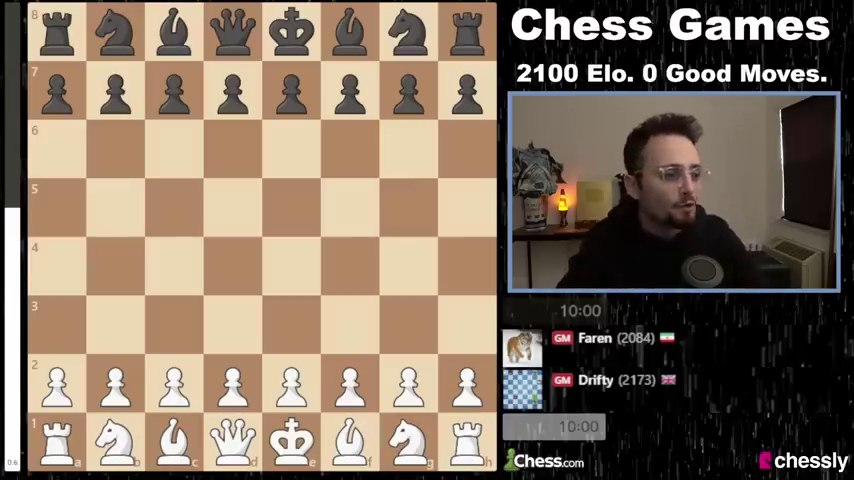

In [38]:
example_image = Image.open('../tests/test_images/gothamchess_1.png')
display(example_image)

In [39]:
def gen_kernel(n):
    template = np.zeros((n, n), dtype=np.uint8)
    half_n = n // 2
    template[:half_n, :half_n] = 255
    template[half_n:, half_n:] = 255
    return template

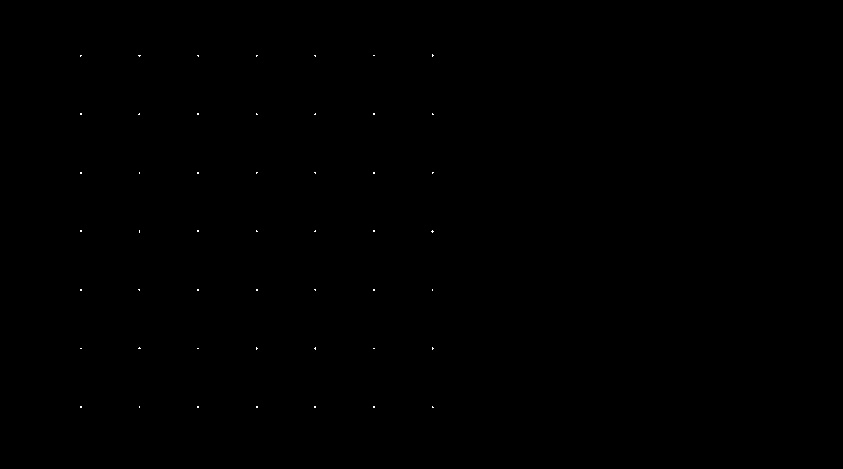

In [40]:
k_size = 12
kernel = gen_kernel(k_size)
img = np.array(example_image.convert('L'), dtype=np.uint8)
match_result = np.abs(cv.matchTemplate(img, kernel, cv.TM_CCOEFF_NORMED))
_, match_result = cv.threshold(match_result, .85, 1, cv.THRESH_BINARY)
imshow(match_result * 255)

In [41]:
match_result.max()

1.0

In [42]:
contours, hierarchy = cv.findContours(match_result.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

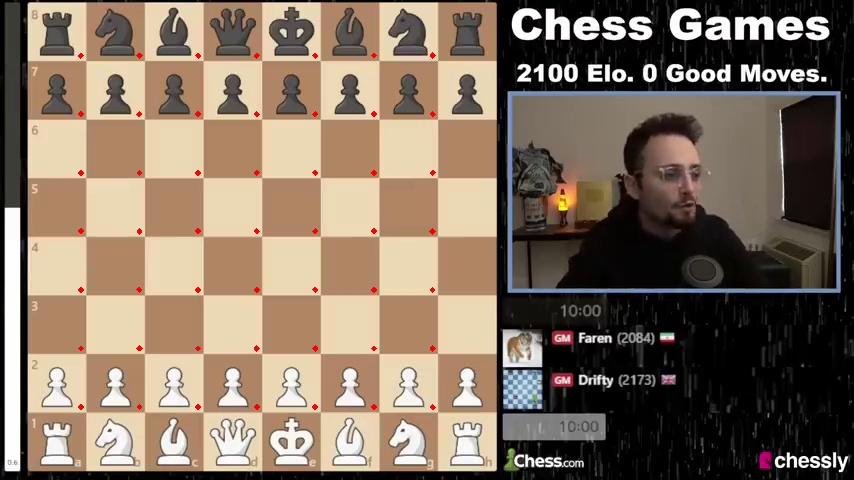

In [43]:
contoured_img = np.asarray(example_image).copy()
contoured_img = cv.cvtColor(contoured_img, cv.COLOR_RGB2BGR)
cv.drawContours(contoured_img, contours, -1, (0, 0, 255), 3)
imshow(contoured_img)

In [44]:
def centerOfContour(contour):
    try:
        M = cv.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return np.asarray([cX, cY], dtype=np.float32)
    except ZeroDivisionError:
        return np.mean(contour[:, 0, :], axis=0)

In [45]:
centers = np.array([centerOfContour(c) for c in contours])
centers += np.array([k_size//2, k_size//2])

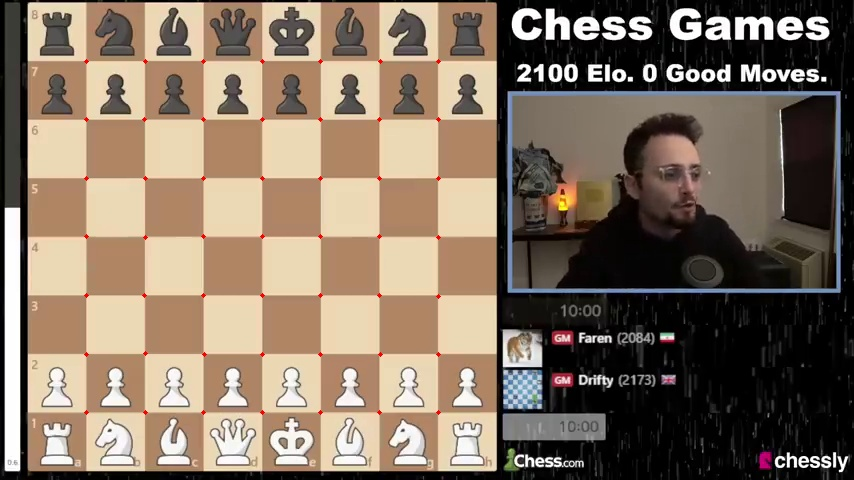

In [46]:
inner_corners_img = np.asarray(example_image).copy()
inner_corners_img = cv.cvtColor(inner_corners_img, cv.COLOR_RGB2BGR)
for c in centers:
    cv.circle(inner_corners_img, np.rint(c).astype(np.int32), 2, (0, 0, 255), -1)
imshow(inner_corners_img)

In [49]:
def centers_to_cb_corners(centers):
    l = centers[:, 0].min()
    r = centers[:, 0].max()
    t = centers[:, 1].min()
    b = centers[:, 1].max()
    width = r - l
    height = b - t
    square_side_len = (width + height) / (2 * 6)
    l -= square_side_len
    t -= square_side_len
    b += square_side_len
    r += square_side_len

    tl = np.array([l, t], dtype=np.int32)
    br = np.array([r, b], dtype=np.int32)
    
    return (tl, br)

In [50]:
tl, br = centers_to_cb_corners(centers)
tl, br

(array([27,  2], dtype=int32), array([496, 471], dtype=int32))

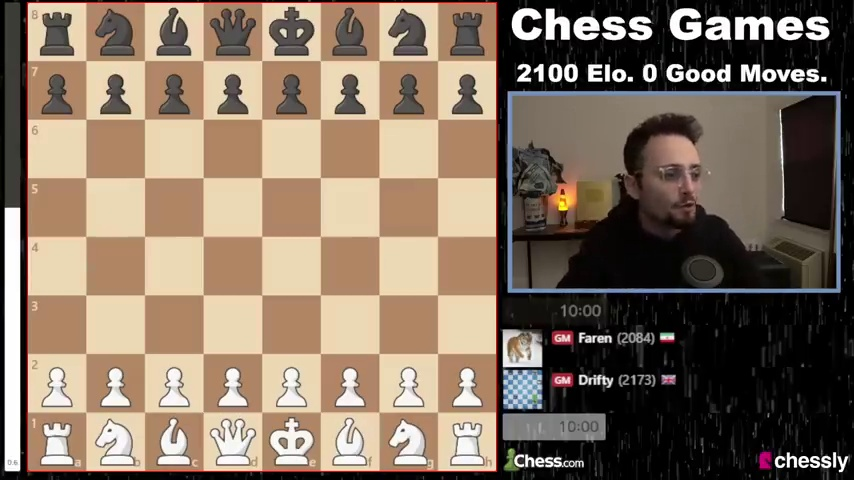

In [51]:
cb_outline_img = np.asarray(example_image).copy()
cb_outline_img = cv.cvtColor(cb_outline_img, cv.COLOR_RGB2BGR)
cv.rectangle(cb_outline_img, tl, br, (0, 0, 255), 1)
imshow(cb_outline_img)